# 2019. 02. 08 시작
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard 커널 공부 및 번역하기

# Stacked Regressions to predict House Prices

## Serigne

### 2017년 7월
### 만약에 이 노트북의 일부를 당신의 노트북에서 사용한다면, 이 노트북의 링크를 달아주면 진심으로 감사하겠습니다.

이 컴피티션은 몇달전 제가 캐글을 시작할 때 많은 도움을 준 중요한 저에게 컴피티션 입니다. 
그 중 많은 좋은 노트북들을 읽을 수 있었고 몇가지 소개해드리겠습니다.

1. [Comprehensive data exploration with Python][1] by Pedro Marcelino: Great and very motivational data analysis

2. [A study on Regression applied to the Ames dataset][2] by Julien CohenSolal : Thorough featrues engineering and deep dive into linear regression analysis but really easy to follow for beginners.

3. [Regularized Linear Models][3] by Alexandru Papiu : Great Starter kernel on modelling and Cross-validation 

이 커널들이 처음 시작하는 모든 분들을 만족시켜주기는 어려울 수 있지만,(더 좋은 다른 커널들도 많습니다.), 데이터 사이언스와 캐글 컴피티션에 대한 감을 얻기에는 충분합니다.

기본적인 연습 후에는 Human Analog라는 사람이 쓴 [이 노트북][7]에서 Feature engineering에 대한 작업들을 살펴보며 조금 자신감을 가질 필요가 있습니다. 

이 데이터셋은 특히 쉽게 다룰 수 있기 때문에, 배웠던 내용 중 스태킹 모델을 적용해보려고 합니다. 이번 노트북에서 2종류의 방식으로 만들어보겠습니다.

이 두 방식들은 일반적인 목적으로 사용될 수 있고, 쉽게 적용하거나 또는 다른 회귀 문제에도 확장할 수 있습니다. 전반적으로 간결하고 쉽게 살펴보겠습니다.

우리가 사용할 Feature engineering 기법은 다른 대단한 노트북들에 비해 어렵지 않습니다.

- **결측치 대체(Imputing missing values)** 데이터를 순차적으로 처리하여 결측치를 대체합니다.

- **변환(Transforming)** 범주형 데이터로 보이는 수치적 데이터를 변환합니다.

- **라벨 인코딩(Label Encoding)** 몇몇 범주형 데이터는 순서가 있는 집합으로 되어있는 정보를 가지고 있는 경우가 있으므로 라벨 인코딩을 합니다.

-  [**Box Cox Transformation**][4] 치우친 변수에 대해 (log-변환 대신에 사용하는 방법) : 이 방법은 조금이지만 LB와 CV에서 **더 좋은 결과**를 보여주었기 때문에 사용합니다.

- **더미 변수 만들기(Getting dummy variables)** 범주형 변수에서 더미 변수로 One-hot encoding 합니다.

이제 베이스로 사용할 모델을 선택해야하는데, 대부분은 sklearn의 모델을 사용하고, [XGBoost][5], [LightGBM][6] 그리고 스태킹 모델과 앙상블을 하기전에 CV를 통해 검증을 하려고합니다. 핵심은 (선형)모델을 이상치에 민감하지 않은(robust) 모델을 만들어야 한다는 점 입니다. 이는 LB와 CV 모두에서 향상된 결과를 보여줍니다.

  [1]: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
  [2]:https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
  [3]: https://www.kaggle.com/apapiu/regularized-linear-models
  [4]: http://onlinestatbook.com/2/transformations/box-cox.html
  [5]: https://github.com/dmlc/xgboost
 [6]: https://github.com/Microsoft/LightGBM
 [7]: https://www.kaggle.com/humananalog/xgboost-lasso

2017년 7월 2일 LB에서 0.11420으로 상위 4% 결과를 얻을 수 있었습니다.

** 모든 분들이 이 노트북을 다 살펴 보았을 때, 스태킹 방식이 명확하게 이해되었으면 좋겠습니다.**

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from scipy.stats import norm, skew

pd.set_option('display.float_format', lambda x : '{:.3f}'.format(x))

from subprocess import check_output
print(check_output(['ls', './input']).decode('utf8'))

data_description.txt
sample_submission.csv
test.csv
train.csv



In [20]:
# 판다스 데이터 프레임으로 train, test 데이터를 불러옵니다.

train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [21]:
#train 데이터셋에서 앞의 5개 데이터를 살펴봅니다.
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [22]:
#test 데이터셋에서 앞의 5개 데이터를 살펴봅니다.
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [23]:
# 데이터 샘플의 수와, 변수의 개수 확인
print('Id 컬럼을 제거하기 전의 train 데이터의 차원 : {}'.format(train.shape))
print('Id 컬럼을 제거하기 전의 test 데이터의 차원 : {}'.format(test.shape))

# Id 컬럼을 따로 변수로 저장합니다.
train_ID = train['Id']
test_ID = test['Id']

#Id 컬럼을 제거합니다. axis=1은 데이터 샘플 축 방향이고, inplace는 데이터 프레임에 바로 해당 함수 적용 유무 입니다.
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

# Id 컬럼을 제거하고, 데이터 샘플의 수와 변수 개수 확인
print('\nId 컬럼을 제거한 후의 train 데이터의 차원 : {}'.format(train.shape))
print('Id 컬럼을 제거한 후의 test 데이터의 차원 : {}'.format(test.shape))


Id 컬럼을 제거하기 전의 train 데이터의 차원 : (1460, 81)
Id 컬럼을 제거하기 전의 test 데이터의 차원 : (1459, 80)

Id 컬럼을 제거한 후의 train 데이터의 차원 : (1460, 80)
Id 컬럼을 제거한 후의 test 데이터의 차원 : (1459, 79)


# 데이터 처리

## 이상치
the Ames Housing Data 문서에서 train 데이터셋에 이상치가 존재한다고 나와 있었습니다.
<br><br>

확인해보겠습니다.

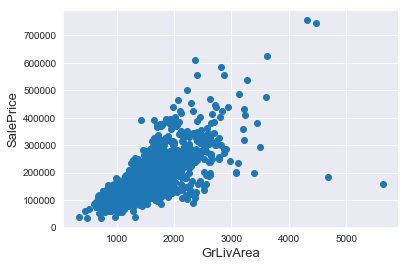

In [24]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

오른쪽 하단에 2개의 극도로 큰 GrLivArea 값을 가지면서 낮은 가격을 갖는 데이터를 살펴볼 수 있습니다.<br>
이러한 값들은 명확하게 이상치로 판단할 수 있습니다. 데이터셋에서 제거하겠습니다.

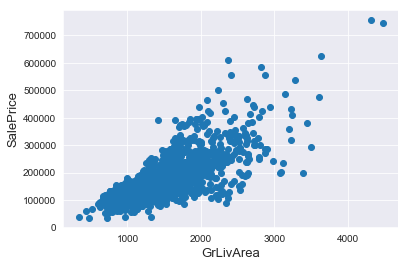

In [8]:
#이상치 제거
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice']<300000)].index)

#시각화로 확인
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#### Note:
이상치 제거는 반드시 해야합니다. 모델에 안좋은 영향을 끼칠 수 있기 때문입니다.
<br>
확률적으로 train 데이터셋에 다른 이상치가 있을 수 있습니다. 하지만 test 데이터셋에도 이상치가 존재할 수 있기 때문에  그러한 데이터를 전부 제거하는 것 또한 모델에 안좋은 영향을 끼칠 수 있습니다.<br>
이러한 이유에서 전부 제거하는 것 대신에 이상치에 민감하지 않은(robust) 모델을 만들어야 한다는 것 입니다.<br>
모델링 부분에서 다시 살펴보겠습니다.

## Target 변수

<br>
**SalePrice**는 예측에 필요한 변수입니다. 그러니 해당 변수를 먼저 분석해 보겠습니다.


 my = 180921.20 and sigma = 79415.29



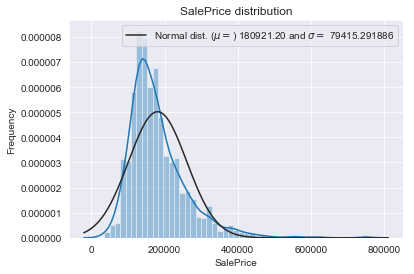

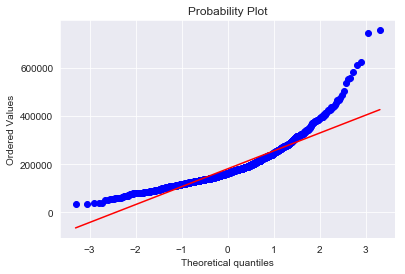

In [25]:
# 분포를 살펴봅니다.
sns.distplot(train['SalePrice'], fit=norm)

# 해당 변수의 평균과 표준 편차를 구합니다.
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n my = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$) {:.2f} and $\sigma=$ {:2f}'.format(mu, sigma)],
          loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot을 그립니다. 실제 분포와 해당 데이터셋이 추출된 분포의 차이를 살펴볼 수 있습니다.
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Target 변수가 오른쪽으로 치우친 것을 확인할 수 있습니다.(선형) 모델은 정규 분포된 데이터를 좋아하기 때문에, 데이터 분포를 정규 분포와 비슷하게 변환할 필요가 있습니다. <br>


#### target 의 Log-변환


 mu = 12.02 and sigma = 0.40



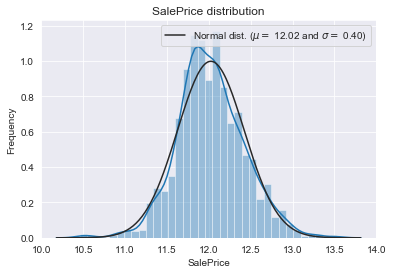

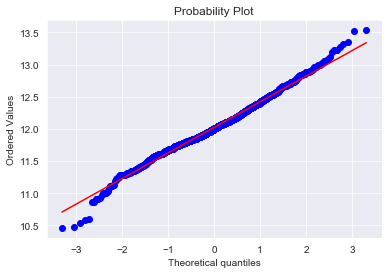

In [10]:
# log(1+x) 모든 컬럼에 1을 더해서 로그화 시키는 numpy 함수를 사용합니다.(변수의 값이 1보다 작으면 -1를 나타내기
# 때문에 이런 함수를 사용하는 것으로 보입니다.)
train['SalePrice'] = np.log1p(train['SalePrice'])

# 새로운 분포 확인
sns.distplot(train['SalePrice'], fit=norm)

# 새로운 분포의 평균, 표준편차를 얻습니다.
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],
          loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot을 그립니다. 실제 분포와 해당 데이터셋이 추출된 분포의 차이를 살펴볼 수 있습니다.
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

## 2019. 02. 24

치우침이 조금 완화 되었고, 데이터가 정규 분포를 띄는 것처럼 보이게 변환 되었습니다.
The skew seems now corrected and the data appears more normally distributed.**

### Features engineering

먼저 train 데이터와 test 데이터를 하나로 합쳐 같이 처리할 수 있도록 합니다.

In [26]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
# reset_index, drop을 True로 하면 index 컬럼을 새로 추가하지 않는다.
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print('데이터 전체 크기 : {}'.format(all_data.shape))

데이터 전체 크기 : (2919, 79)
